# Testing Multifidelity MES against a Synthetic Function (June 2024)

These plots will be needed for the write-up.

In [1]:

import pandas as pd
import numpy as np
import torch

from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.models.cost import AffineFidelityCostModel
from botorch.acquisition.cost_aware import InverseCostWeightedUtility
from botorch.acquisition.knowledge_gradient import qMultiFidelityKnowledgeGradient
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.acquisition.utils import project_to_target_fidelity
from botorch.acquisition.max_value_entropy_search import qMultiFidelityMaxValueEntropy
from botorch.acquisition import PosteriorMean
from botorch.optim.optimize import optimize_acqf
import numpy as np
from scipy.spatial.distance import cdist
from botorch import fit_gpytorch_mll
torch.set_printoptions(precision=12, sci_mode=False)
import copy
import math

import warnings
warnings.filterwarnings("ignore")

def covSEard(hyp, x, z):
    """
    ARD covariance:
        x is of dimension n X D
        y is of dimension m X D
    """
    hyp = np.exp(hyp)

    D = x.shape[1]
    X = (1 / hyp[:D]) * x

    Z = (1 / hyp[:D]) * z
    K = cdist(X, Z)

    K = hyp[D] ** 2 * np.exp(-K ** 2 / 2)

    return K

def rkhs_synth(x):
    """
    RKHS Function
        Description: Synthetic heteroscedastic function generated from 2 Squared Exponential kernels
                     for Bayesian Optimization method evaluation tasks
        Evaluated: x \in [0,1]
        Global Maximum: x=0.89235, f(x)=5.73839
        Authors: Ziyu Wang, John Assael and Nando de Freitas
    """

    x = np.atleast_2d(x)
    hyp_1 = np.log(np.array([0.1, 1]))
    hyp_2 = np.log(np.array([0.01, 1]))

    support_1 = [0.1, 0.15, 0.08, 0.3, 0.4]
    support_2 = [0.8, 0.85, 0.9, 0.95, 0.92, 0.74, 0.91, 0.89, 0.79, 0.88, 0.86, 0.96, 0.99, 0.82]
    vals_1 = [4, -1, 2., -2., 1.]
    vals_2 = [3, 4, 2, 1, -1, 2, 2, 3, 3, 2., -1., -2., 4., -3.]

    f = sum([vals_2[i] * covSEard(hyp_2, np.atleast_2d(np.array(s)), x) for i, s in enumerate(support_2)])
    f += sum([vals_1[i] * covSEard(hyp_1, np.atleast_2d(np.array(s)), x) for i, s in enumerate(support_1)])

    return float(f)

In [23]:
import random
import time

def setUpSampleSpace(spaceSize=100):
    Xpr = [random.random() for i in range(spaceSize)]
    
    domain = []
    for x in Xpr:
       domain.append( [x, 1.0, rkhs_synth(x)])
       domain.append( [x, 0.5, rkhs_synth(x) + random.gauss(0, 1)])
    
    domain = np.array(domain)
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fileName = 'SampleSpaces/'+timestr + '.csv'
    np.savetxt(fileName, domain, delimiter=',')

    return fileName

def setUpInitialData(sampleSpaceName, initialSize=10):
   sampleSpace = np.loadtxt(sampleSpaceName, delimiter=',')
   size = len(sampleSpace) 
   index_store = random.sample(range(size), initialSize)
   fidelity_history = sampleSpace[index_store, 1]
   train_X = sampleSpace[index_store, :-1]
   train_obj = sampleSpace[index_store, -1:]
   return torch.tensor(train_X), torch.tensor(train_obj), sampleSpace, index_store, fidelity_history.flatten().tolist()

In [24]:
file = setUpSampleSpace(2000)
# train_X, train_obj, domain, index_store, budget = setUpInitialData(file, 10)

In [5]:
def runMes(model, Xrpr):
    Xrpr = torch.tensor(Xrpr)
    bounds = torch.tensor([[0.0] * Xrpr.shape[1], [1.0] * Xrpr.shape[1]])
    candidate_set = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(10000, 1)
    target_fidelities = {1: 1.0}
            
    cost_model = AffineFidelityCostModel(fidelity_weights={1: 1.0}, fixed_cost=1.0)
    cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

    acquisition = qMultiFidelityMaxValueEntropy(
            model=model,
            cost_aware_utility=cost_aware_utility,
            project=lambda x: project_to_target_fidelity(X=x, target_fidelities=target_fidelities),
            candidate_set=candidate_set,
        )
    acquisitionScores =  acquisition.forward(Xrpr.reshape(-1,1, Xrpr.shape[1]))
    return acquisitionScores

In [6]:
def runKG(model, Xrpr):
    Xrpr = torch.tensor(Xrpr)
    bounds = torch.tensor([[0.0] * Xrpr.shape[1], [1.0] * Xrpr.shape[1]])
    target_fidelities = {1: 1.0}
            
    cost_model = AffineFidelityCostModel(fidelity_weights={1: 1.0}, fixed_cost=1.0)
    cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

    curr_val_acqf = FixedFeatureAcquisitionFunction(
        acq_function=PosteriorMean(model),
        d=Xrpr.shape[1],
        columns=[Xrpr.shape[1]-1],
        values=[1],
    )                
    _, current_value = optimize_acqf(
        acq_function=curr_val_acqf,
        bounds=bounds[:,:-1],
        q=1,
        num_restarts= 1,
        raw_samples=1
    )
    acquisition = qMultiFidelityKnowledgeGradient(
            model=model,
            cost_aware_utility=cost_aware_utility,
            project=lambda x: project_to_target_fidelity(X=x, target_fidelities=target_fidelities),
            current_value=current_value,
            num_fantasies= 2
        )
    acquisitionScores =  acquisition.evaluate(Xrpr.reshape(-1,1, Xrpr.shape[1]), bounds=bounds).detach()
    return acquisitionScores

In [7]:
def optimiseAcquisitionFunction(sortedAcqusitionScores, domain, trainingData, index_store):
    # X_detached = trainingData.detach().numpy()
    # def checkFunction(candidate, set):
    #     for x in set:
    #         if np.array_equal(candidate[:-1], x):
    #             return True
    #     return False
    def checkIndexNotAlreadyEvaluated(candidate, set):
        return candidate in set
    
    for i in range(domain.shape[0]):
        if not checkIndexNotAlreadyEvaluated(sortedAcqusitionScores[i].item(), index_store):
            index_store.append(sortedAcqusitionScores[i].item())
            return domain[sortedAcqusitionScores[i], 0], domain[sortedAcqusitionScores[i], 1], domain[sortedAcqusitionScores[i], 2]
            # , sortedAcqusitionScores[i]

In [8]:
def run_entire_cycle(train_x_full, train_obj, domain, fidelity_history, index_store, func, no_of_iterations=100000, allocated_budget=100000):
    train_x_full = copy.deepcopy(train_x_full)
    train_obj = copy.deepcopy(train_obj)
    fidelity_history = copy.deepcopy(fidelity_history)
    index_store = copy.deepcopy(index_store)
    
    domain_X_only = domain[:, 0:-1]
    budget_sum = sum(fidelity_history)
    iteration_counter = 0
    while budget_sum  <= allocated_budget - 1 and iteration_counter < no_of_iterations: 
        # The - 1 important in the budget (as well as the equal) as the check happens at the start and we only really care about high-fidelity points.
        # Consider a budget of 40, and when we hit the sum at 39. We would want the subsequent step to be the last
        # as at most we can add 1. If we instead only add 0.5, you could argue that stopping at 39.5 is premature
        # and we could go another step since it's possible to get another low-fidelity point, but this does not interest us.
        # It's the high-fidelity points we care about and then that would exceed the budget.
        model = SingleTaskMultiFidelityGP(train_x_full, train_obj, data_fidelity=1)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)  
        acquisitionScores = func(model=model, Xrpr=domain_X_only)
        sorted_acqusition_scores = acquisitionScores.argsort(descending=True)
        top_candidate, fidelity, evaluation = optimiseAcquisitionFunction(sorted_acqusition_scores, domain, train_x_full, index_store)
        fidelity_history.append(fidelity)
        train_x_full = torch.cat([train_x_full, torch.tensor([top_candidate, fidelity]).unsqueeze(0)])
        train_obj = torch.cat([train_obj, torch.tensor([evaluation]).unsqueeze(-1)])
        iteration_counter+=1
        budget_sum += fidelity
    cumulative_cost = [fidelity_history[0]]
    for i in range(len(fidelity_history) - 1):
        cumulative_cost.append(cumulative_cost[-1] + fidelity_history[i+1])
    return train_x_full, train_obj, cumulative_cost, index_store

def run_entire_cycle_random(no_of_iterations, domain):
    #Here we will only consider high-fidelity points since we are just randomly choosing points and ignore the intitial sample.
    #Since high-fidelity points have a fidleity of 1 this means the allocated_budget is the same as the number of iterations.
    high_fidelity_points = domain[np.where(domain[:, 1] == 1.0)]
    number_of_hf_points = len(high_fidelity_points)
    index_store = random.sample(range(number_of_hf_points), no_of_iterations)
    train_X_full = high_fidelity_points[index_store][:, :-1]
    train_obj = high_fidelity_points[index_store][:, -1]
    cumulative_cost = list(range(1, no_of_iterations + 1))
    return torch.tensor(train_X_full), torch.tensor(train_obj).unsqueeze(-1), cumulative_cost, [2 * x  for x in index_store]


In [38]:
N_ITER = 30
N_INIT = 5
ALLOCATED_BUDGET = 50
# fileName = 'SampleSpaces/20240606-114441.csv'
fileName = file
train_x_full, train_obj, domain, index_store, fidelity_history = setUpInitialData(fileName, N_INIT)

train_x_full_mes, train_obj_mes, cumulative_cost_mes, index_store_mes = run_entire_cycle(
    train_x_full, 
    train_obj, 
    domain, 
    fidelity_history,
    index_store,
    runMes,
    allocated_budget=ALLOCATED_BUDGET
    )

train_x_full_rand, train_obj_rand, cumulative_cost_rand, index_store_rand= run_entire_cycle_random(ALLOCATED_BUDGET, domain)

In [40]:
#Plot the samples.
import matplotlib.pyplot as plt

def plot_fidelities(samples, targets, title, total_domain, colours=['blue','red','green']):
    max_in_space= np.max(total_domain[np.where(total_domain[:, 1] == 1.0)])
    samples = samples.detach().numpy()
    targets = targets.detach().numpy()
    nb_iterations = len(samples) - 1
    fidelities = list(dict.fromkeys(samples[:, 1]))
    print(fidelities)
    fidelities.sort()
    for fidelity in fidelities:
        fidelity_target=[]
        fidelity_iteration=[]
        for i in range(0, nb_iterations):
            if (samples[i,1] == fidelity):
                fidelity_target.append(targets[i])
                fidelity_iteration.append(i)
        # maximum_target.append(max(df_total[df_total['fidelity']==fidelity]['target']))
        legend_text = f'Fidelity: {fidelity}'
        plt.scatter(fidelity_iteration, fidelity_target, label=legend_text, color=colours[fidelities.index(fidelity)])
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for Best Fidelity')
    plt.legend(loc="lower right")
    plt.xlabel("Iteration Number")
    plt.ylabel("Target")
    plt.ylim([min(targets)-1, max(targets)+1])
    plt.title(title)

[1.0, 0.5]


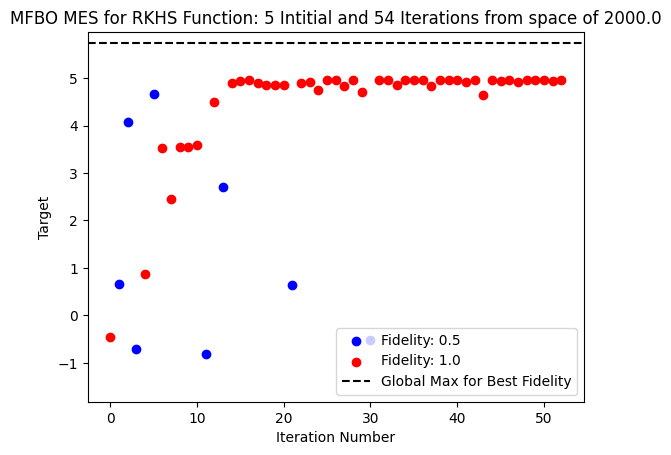

In [50]:
plot_fidelities(train_x_full_mes, train_obj_mes, f'MFBO MES for RKHS Function: {N_INIT} Intitial and {len(train_x_full_mes)} Iterations from space of {len(domain)/2}', domain)

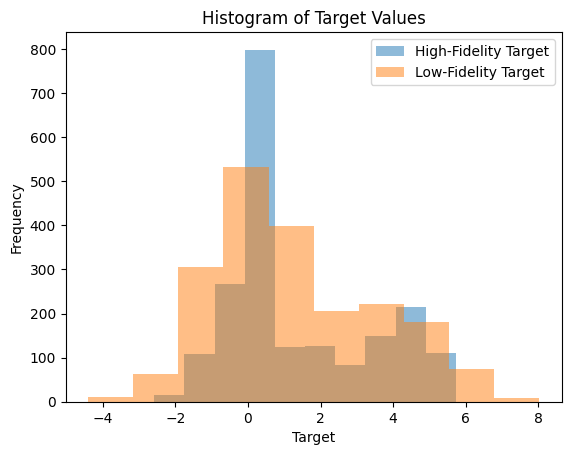

In [42]:
#Shows distribution of High-fidelity and Low-fidelity targets.
def plot_histogram(domain):
    high_fidelity = domain[np.where(domain[:, 1]==1.0)]
    low_fidelity = domain[np.where(domain[:, 1]==0.5)]
    plt.hist(high_fidelity[:, -1], label='High-Fidelity Target', bins=10, alpha=0.5)
    plt.hist(low_fidelity[:, -1], label='Low-Fidelity Target', bins=10, alpha=0.5)
    plt.title('Histogram of Target Values')
    plt.xlabel('Target')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show() 

plot_histogram(domain)

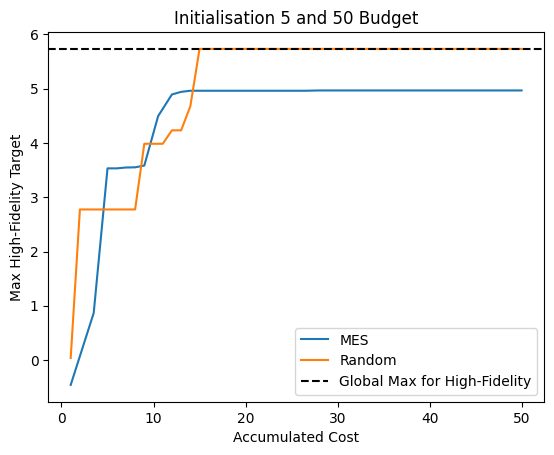

In [43]:
# Here we plot the maximum high-fidelity target reached so far with a given cost. 
def plot_cost(domain, dictionary, title): 
    max_in_space= np.max(domain[np.where(domain[:, 1] == 1.0)])
    for search_alg in dictionary:
        train_x_full, train_obj, cumulative_cost = dictionary[search_alg]
        cumulative_cost_array = np.array(cumulative_cost)
        hf_indices = np.where(train_x_full[:, 1]==1.0)
        high_fidelity_obj = train_obj[np.where(train_x_full[:, 1]==1.0)].detach().numpy()
        accum_target = []
        for i in range(len(high_fidelity_obj)):
            accum_target.append(max(high_fidelity_obj[0:i+1]))

        plt.plot(cumulative_cost_array[hf_indices ], accum_target, label=search_alg)    
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for High-Fidelity')
    plt.xlabel('Accumulated Cost')
    plt.ylabel('Max High-Fidelity Target')
    plt.title(title)
    plt.legend()

modelDict = {"MES": (train_x_full_mes, train_obj_mes, cumulative_cost_mes), 
             "Random": (train_x_full_rand, train_obj_rand, cumulative_cost_rand) 
             }    
plot_cost(domain, modelDict,f'Initialisation {N_INIT} and {ALLOCATED_BUDGET} Budget' )

In [47]:
train_x_full_mes

tensor([[    0.378650273979,     1.000000000000],
        [    0.832957387441,     0.500000000000],
        [    0.077434401253,     0.500000000000],
        [    0.677113065595,     0.500000000000],
        [    0.808978328414,     1.000000000000],
        [    0.000011716137,     0.500000000000],
        [    0.000011716137,     1.000000000000],
        [    0.999875782171,     1.000000000000],
        [    0.000526105917,     1.000000000000],
        [    0.000638470462,     1.000000000000],
        [    0.001715622789,     1.000000000000],
        [    0.868717187510,     0.500000000000],
        [    0.117527209466,     1.000000000000],
        [    0.159937212200,     0.500000000000],
        [    0.093355564564,     1.000000000000],
        [    0.087015531401,     1.000000000000],
        [    0.073433778215,     1.000000000000],
        [    0.060921890392,     1.000000000000],
        [    0.058305866845,     1.000000000000],
        [    0.057249266742,     1.000000000000],


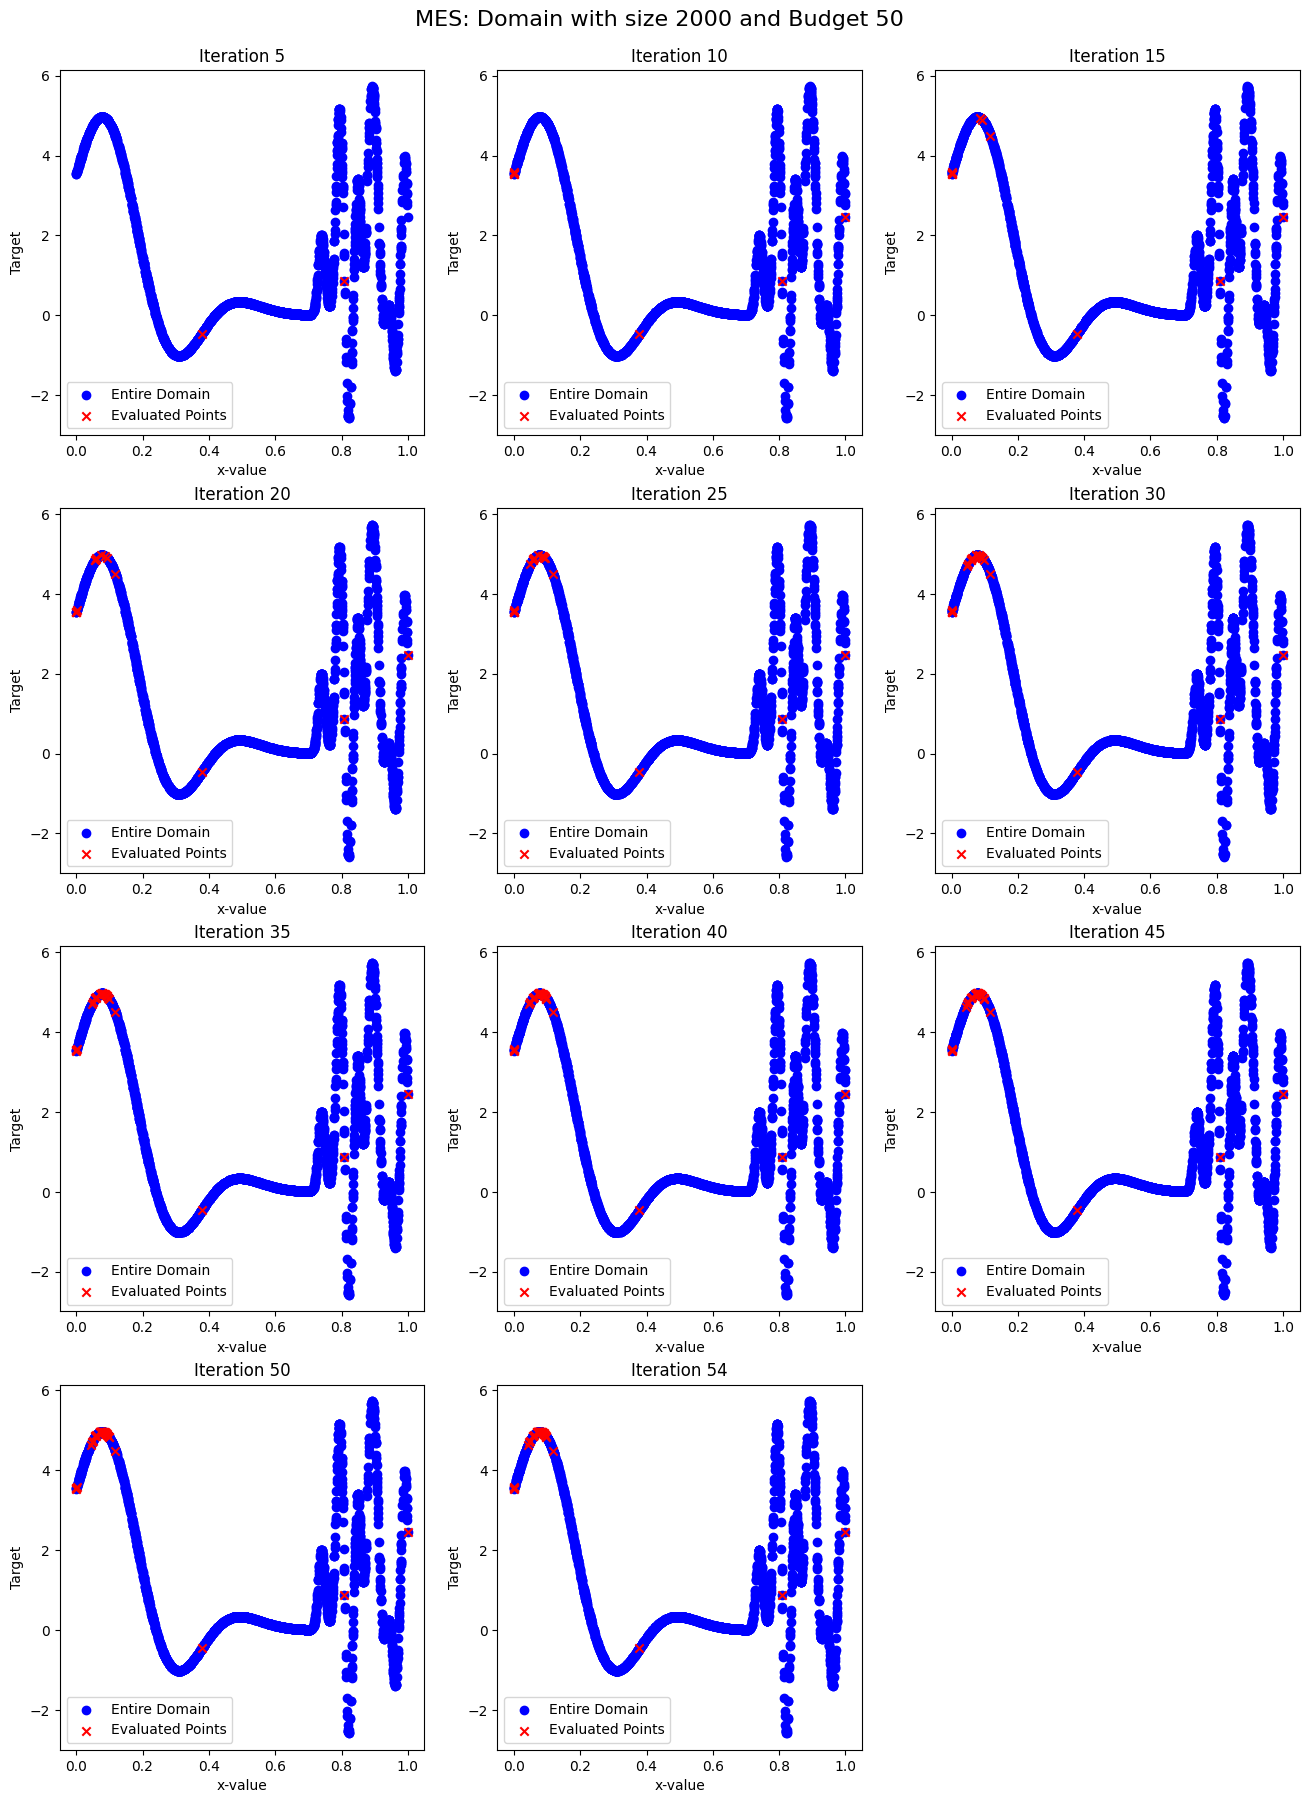

In [61]:
# Here we plot the HF points that were chosen by each fidelity.
def plot_target_per_iteration(domain, train_x_full, train_obj, iteration_no):
    hf_points = domain[np.where(domain[:, 1]==1.0)]
    hf_sorted_arg = hf_points[:, 0].argsort()
    hf_points = hf_points[hf_sorted_arg]
    plt.scatter(hf_points[:, 0], hf_points[:, -1], color='blue', label = 'Entire Domain')
    x_allfidelity_up_to_iter = train_x_full[0 : iteration_no + 1 ]
    y_allfidelity_up_to_iter = train_obj[0 : iteration_no + 1 ]
    plt.scatter(x_allfidelity_up_to_iter[np.where(x_allfidelity_up_to_iter[:, 1] == 1.)][:, 0], 
                y_allfidelity_up_to_iter[np.where(x_allfidelity_up_to_iter[:, 1] == 1.)][:, 0], 
                color='red',
                marker='x', 
                label='Evaluated Points' )
    plt.xlabel('x-value')
    plt.ylabel('Target')
    plt.title(f'Iteration {iteration_no}')
    plt.legend()

def plot_target_per_iteration_range(domain, train_x_full, train_obj, iteration_range):
    figure = plt.figure(figsize=(16, 20))
    no_of_rows = math.ceil(len(iteration_range) / 3) 
    for id, image_no in enumerate(range(len(iteration_range))):
        plt.subplot(no_of_rows, 3, id + 1)
        plot_target_per_iteration(domain, train_x_full, train_obj, iteration_range[image_no])
    plt.suptitle(f'MES: Domain with size {int(len(domain)/2)} and Budget {ALLOCATED_BUDGET}', size=16)
    plt.subplots_adjust(top=0.95)


# plot_target_per_iteration(domain, train_x_full_mes, train_obj_mes, 15)
plot_target_per_iteration_range(domain, train_x_full_mes, train_obj_mes, [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, len(train_x_full_mes)])


## Batches and Average
Now we consuder multiple runs and average the results.

In [102]:
# Adding in batch functionality
def run_entire_cycle_batch(experiments, fileName, initial_sample, func, no_of_iterations=10000, allocated_budget=10000):
    train_x_full_batch = []
    train_obj_batch = []
    cumulative_cost_batch = [] 
    index_store_batch = []
    for j in range(experiments):
        train_x_full, train_obj, domain, index_store, fidelity_history = setUpInitialData(fileName, initial_sample)
        train_x_full, train_obj, cumulative_cost, index_store = run_entire_cycle(
            train_x_full, 
            train_obj, 
            domain, 
            fidelity_history, 
            index_store, 
            func,
            no_of_iterations,
            allocated_budget
)  
        train_x_full_batch.append(train_x_full)
        train_obj_batch.append(train_obj)
        cumulative_cost_batch.append(cumulative_cost)
        index_store_batch.append(index_store)
    return train_x_full_batch, train_obj_batch, cumulative_cost_batch, index_store_batch

def run_entire_cycle_random_batch(no_of_iterations, experiments, fileName):
    #Here we will only consider high-fidelity points since we are just randomly choosing points and ignore the intitial sample
    train_X_full_batch = []
    train_obj_batch = []
    cumulative_cost_batch = []
    index_store_batch = []
    for i in range(experiments):
        _, _, domain, _, _ = setUpInitialData(fileName, 10)
        train_X_full, train_obj, cumulative_cost, index_store = run_entire_cycle_random(no_of_iterations, domain)
        train_X_full_batch.append(train_X_full)
        train_obj_batch.append(train_obj)
        cumulative_cost_batch.append(cumulative_cost)
        index_store_batch.append(index_store)
    return train_X_full_batch, train_obj_batch, cumulative_cost_batch, index_store_batch

In [58]:
# Debug batch functionality (Ignore)
# def run_entire_cycle_batch_debug(no_of_iterations, experiments, train_x_full_input, train_obj_input, domain, index_store_input, budget_input, func):
#     train_x_full_batch = []
#     train_obj_batch = []
#     cumulative_cost_batch = [] 
#     index_store_batch = []
#     acqusiiton_scores_batch = []
#     for j in range(experiments):
#         train_x_full = copy.deepcopy(train_x_full_input)
#         train_obj = copy.deepcopy(train_obj_input)
#         index_store = copy.deepcopy(index_store_input)
#         budget = copy.deepcopy(budget_input)
#         domain_X_only = domain[:, 0:-1]
#         acquisition_scores_array = []  
#         for i in range(no_of_iterations):
#             model = SingleTaskMultiFidelityGP(train_x_full, train_obj, data_fidelity=1)
#             mll = ExactMarginalLogLikelihood(model.likelihood, model)
#             fit_gpytorch_mll(mll)  
#             acquisitionScores = func(model=model, Xrpr=domain_X_only)
#             sorted_acqusition_scores = acquisitionScores.argsort(descending=True)
#             top_candidate, fidelity, evaluation, acqusition_score_index = optimiseAcquisitionFunction(sorted_acqusition_scores, domain, train_x_full, index_store)
#             budget.append(fidelity)
#             acquisition_scores_array.append(acquisitionScores[acqusition_score_index])
#             train_x_full = torch.cat([train_x_full, torch.tensor([top_candidate, fidelity]).unsqueeze(0)])
#             train_obj = torch.cat([train_obj, torch.tensor([evaluation]).unsqueeze(-1)])
#         cumulative_cost = [budget[0]]
#         for i in range(len(budget) - 1):
#             cumulative_cost.append(cumulative_cost[-1] + budget[i+1])
#         train_x_full_batch.append(train_x_full)
#         train_obj_batch.append(train_obj)
#         cumulative_cost_batch.append(cumulative_cost)
#         index_store_batch.append(index_store)
#         acqusiiton_scores_batch.append(acquisition_scores_array)
#     return train_x_full_batch, train_obj_batch, cumulative_cost_batch, index_store_batch, acqusiiton_scores_batch

In [63]:
# Debug to understand why repeated runs with same initial sample are slightly different. Float error?
# import warnings
# warnings.filterwarnings('ignore')
# N_ITER = 30
# N_EXP = 5
# fileName = 'SampleSpaces/20240606-114441.csv'
# train_x_full, train_obj, domain, index_store, budget = setUpInitialData(fileName, 10)

# train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch, index_store_mes_batch, acquition_scores_batch = run_entire_cycle_batch_debug(
#     N_ITER,
#     N_EXP, 
#     train_x_full, 
#     train_obj, 
#     domain, 
#     budget,
#     index_store,
#     runMes
#     )

In [ ]:
# IGNORE - DEBUG CODE
# print(train_x_full_mes_batch[0][:,0])
# print(train_x_full_mes_batch[1][:,0])
# print(acquition_scores_batch[0])
# print(acquition_scores_batch[1])
# print(len(train_obj_mes_batch[0][np.where(train_x_full_mes_batch[0][:,1] == 1)]))
# print(len(train_obj_mes_batch[1][np.where(train_x_full_mes_batch[1][:,1] == 1)]))

In [19]:
timestr = time.strftime("%Y%m%d-%H%M%S")
fileName = 'SampleSpaces/'+timestr + '.csv'
KG_dict = {
    "train_X_batch": train_x_full_mes_batch,
    "train_obj_batch": train_obj_mes_batch, 
    "cumulative_batch": cumulative_cost_mes_batch, 
    "index_batch": index_store_mes_batch
      }

np.savetxt(fileName, np.array(KG_dict), delimiter=',')

ValueError: Expected 1D or 2D array, got 0D array instead

In [104]:
N_ITER_BATCH = 30
N_EXP_BATCH = 8
INIT_SAMPLE_SIZE_BATCH=5
ALLOCATED_BUDGET_BATCH = 35
fileName = 'SampleSpaces/20240606-114441.csv'

train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch, index_store_mes_batch = run_entire_cycle_batch(
    N_EXP_BATCH,
    fileName,
    INIT_SAMPLE_SIZE_BATCH, 
    runMes,
    allocated_budget = ALLOCATED_BUDGET_BATCH,
    );

train_x_full_random_batch, train_obj_random_batch, cumulative_cost_random_batch, index_store_random_batch = run_entire_cycle_random_batch(
    ALLOCATED_BUDGET_BATCH,
    N_EXP_BATCH,
    fileName
    );

searchDictBatch = {
    "MES": (train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch), 
    "Random": (train_x_full_random_batch, train_obj_random_batch, cumulative_cost_random_batch)
                   }   

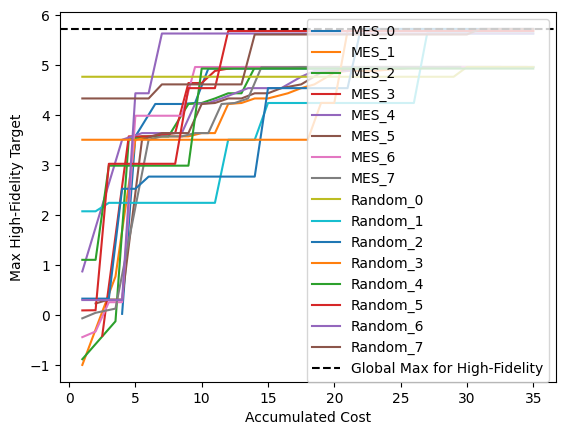

In [105]:
# This is code to debug the batch process a few cells later, showing the different runs individually, rather than averaged.
def plot_cost_batch_individual(domain, dictionary): 
    max_in_space= np.max(domain[np.where(domain[:, 1] == 1.0)])
    for search_alg in dictionary:
        train_x_full, train_obj, cumulative_cost = dictionary[search_alg]
        for j in range(len(train_x_full)):
            cumulative_cost_array = np.array(cumulative_cost[j])
            hf_indices = np.where(train_x_full[j][:, 1]==1.0)
            high_fidelity_obj = train_obj[j][np.where(train_x_full[j][:, 1]==1.0)].detach().numpy()
            accum_target = []
            for i in range(len(high_fidelity_obj)):
                accum_target.append(max(high_fidelity_obj[0:i+1]))

            plt.plot(cumulative_cost_array[hf_indices ], accum_target, label=f"{search_alg}_{j}")    
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for High-Fidelity')
    plt.xlabel('Accumulated Cost')
    plt.ylabel('Max High-Fidelity Target')
    plt.legend()
    
plot_cost_batch_individual(domain, searchDictBatch)

In [82]:
# Helper Function for Batch Case. This takes the cumulative cost array, extracts the high-fidelity targets, calculates the maximum up-to-that-stage
# and then spreads it out evenly over an  assigned range of regular intervals (of cumulative cost).
# i.e. the cost_range_input, so that we can compare different runs/experiments and compute an average.
# For example, if we have accumulated cost of [1, 1.5, 2, 2.5, 3.5] with targets [2.1, 0.9, 3.5, 2.3, 5].
# This should give an output over:
# [1,   1.5, 2,   2.5,   3,   3.5, 4, 4.5, 5  ] 
# [2.1, 2.1, 3.5, 3.5,   3.5, 5,   5,   5,  5 ]

def discretise_cost_and_maximise(high_fidleity_points, cost_range_input, cumulative_cost_array_input, hf_indices_input):
    accum_target = []
    # This part generates the accumulated maximum of just each high-fidleity point so far.
    for i in range(len(high_fidleity_points)):
        accum_target.append(max(high_fidleity_points[0:i+1]))

    accum_target = np.array(accum_target)
    max_target = []
    for id, x in enumerate(cost_range_input):
        if x in cumulative_cost_array_input[ hf_indices_input ]:
            max_target.append(accum_target[np.where(cumulative_cost_array_input[ hf_indices_input ] == x )[0]][0].item())
        elif id == 0:
            max_target.append(0)
        else:
            max_target.append(max_target[id-1])
    return max_target
#Unit-test:
print(discretise_cost_and_maximise( [2.1, 0.9, 3.5, 2.3, 5], [1,   1.5, 2,   2.5,   3,   3.5, 4, 4.5, 5  ] , np.array([1, 1.5, 2, 2.5, 3.5]), [0,1,2,3,4]))

[2.1, 2.1, 3.5, 3.5, 3.5, 5.0, 5.0, 5.0, 5.0]


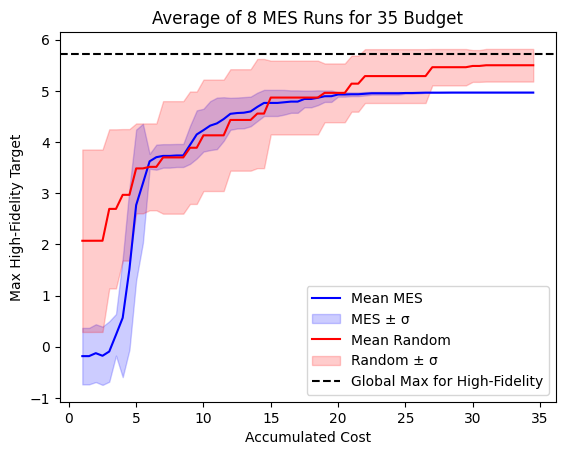

In [108]:
# Here we plot the mean maximum high-fidelity target reached so far with SD for a batch of experiments. 
def plot_cost_batch(domain, dictionary, title, allocated_budget, colour=['blue', 'red', 'green']): 
    max_in_space= np.max(domain[np.where(domain[:, 1] == 1.0)])
    for id, search_alg in enumerate(dictionary):
        aggregate_max_target = []
        train_x_full_batch, train_obj_batch, cumulative_cost_batch = dictionary[search_alg]
        cost_range = list(np.arange(1,allocated_budget,0.5))
        
        for batch_no in range(len(train_x_full_batch)):
            cumulative_cost_array = np.array(cumulative_cost_batch[batch_no])
            hf_indices = np.where(train_x_full_batch[batch_no][:, 1]==1.0)
            high_fidelity_obj = train_obj_batch[batch_no][np.where(train_x_full_batch[batch_no][:, 1]==1.0)].detach().numpy().squeeze(-1)
            max_target = discretise_cost_and_maximise(high_fidelity_obj, cost_range, cumulative_cost_array, hf_indices)
            aggregate_max_target.append(max_target)
        
        maximum_aggregate_mean = np.mean(aggregate_max_target, axis = 0)
        maximum_aggregate_lowerbound = maximum_aggregate_mean - np.std(aggregate_max_target, axis = 0)
        maximum_aggregate_upperbound = maximum_aggregate_mean + np.std(aggregate_max_target, axis = 0)
        plt.plot(cost_range, maximum_aggregate_mean, label=f'Mean {search_alg}', color=colour[id])
        plt.fill_between(x=cost_range, y1=maximum_aggregate_lowerbound, y2=maximum_aggregate_upperbound, color=colour[id], alpha=0.2, label=f'{search_alg} \xb1 \u03C3')    
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for High-Fidelity')
    plt.xlabel('Accumulated Cost')
    plt.ylabel('Max High-Fidelity Target')
    plt.title(title)
    plt.legend(loc='lower right')

plot_cost_batch(domain, searchDictBatch, f'Average of {N_EXP_BATCH} MES Runs for {ALLOCATED_BUDGET_BATCH} Budget', ALLOCATED_BUDGET_BATCH )